# Table of contents

* [Project Description](#intro)
* [1 Data description](#data_description)
* [2 Data Preparation](#data_prep)
* [3 Data Analysis](#analysis)
* [4 Formation](#formation)
* [5 Test](#test)
* [6 Conclusions](#end)  

# Project description


The company Sweet Lift Taxi has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the number of taxi orders for the next hour. Build a model for that prediction.


The RMSE metric in the test set must not exceed 48.


## Data description


The data is stored in the `taxi.csv` file.

The number of orders is in the `num_orders` column.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgbm

from sklearn.model_selection import RandomizedSearchCV

**Importaremos los datos directamente con nuestra columna de fechas como índice.**

In [ ]:
data = pd.read_csv("/datasets/taxi.csv", parse_dates=[0], index_col=[0])

In [ ]:
data.head(7)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7


In [ ]:
data_series = data["num_orders"]

In [ ]:
data_series.head()

datetime
2018-03-01 00:00:00     9
2018-03-01 00:10:00    14
2018-03-01 00:20:00    28
2018-03-01 00:30:00    20
2018-03-01 00:40:00    32
Name: num_orders, dtype: int64

## Preparation

**At this point we will resample our data per hour.**

In [ ]:
data_resampled = data_series.resample("1H").mean()
data_resampled.head()

datetime
2018-03-01 00:00:00    20.666667
2018-03-01 01:00:00    14.166667
2018-03-01 02:00:00    11.833333
2018-03-01 03:00:00    11.000000
2018-03-01 04:00:00     7.166667
Freq: H, Name: num_orders, dtype: float64

In [ ]:
data_resampled.tail()

datetime
2018-08-31 19:00:00    22.666667
2018-08-31 20:00:00    25.666667
2018-08-31 21:00:00    26.500000
2018-08-31 22:00:00    37.166667
2018-08-31 23:00:00    34.166667
Freq: H, Name: num_orders, dtype: float64

## Analysis


**To begin our analysis we start by reviewing the average taxi orders per hour.**

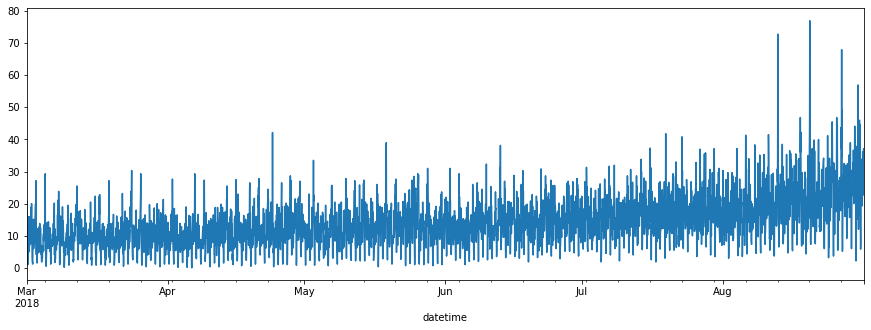

In [ ]:
data_series.resample("1H").mean().plot(figsize=(15, 5))
plt.show()

**At first glance we see a slight increase in the summer months, it is time to review the trend with other graphs.**

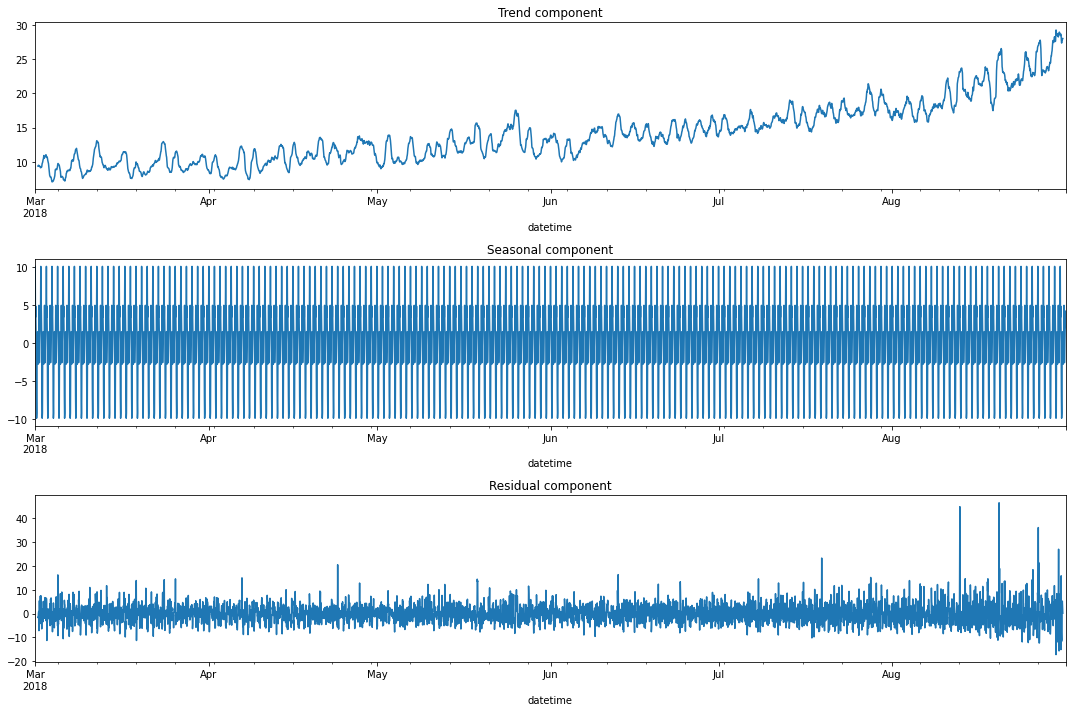

In [ ]:
data_resampled = data_series.resample("1H").mean()
decomposed_series = seasonal_decompose(data_resampled)

plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed_series.trend.plot(ax=plt.gca())
plt.title("Trend component")

plt.subplot(312)
decomposed_series.seasonal.plot(ax=plt.gca())
plt.title("Seasonal component")

plt.subplot(313)
decomposed_series.resid.plot(ax=plt.gca())
plt.title("Residual component")

plt.tight_layout()

**We checked that the trend rises towards the end of our time series and likewise there are more stochastic variations in our residual component at the conclusion of the series.**

In [ ]:
combined_series = decomposed_series.trend + decomposed_series.resid + decomposed_series.seasonal

combined_series.head(15)

datetime
2018-03-01 00:00:00         NaN
2018-03-01 01:00:00         NaN
2018-03-01 02:00:00         NaN
2018-03-01 03:00:00         NaN
2018-03-01 04:00:00         NaN
2018-03-01 05:00:00         NaN
2018-03-01 06:00:00         NaN
2018-03-01 07:00:00         NaN
2018-03-01 08:00:00         NaN
2018-03-01 09:00:00         NaN
2018-03-01 10:00:00         NaN
2018-03-01 11:00:00         NaN
2018-03-01 12:00:00    5.000000
2018-03-01 13:00:00    5.333333
2018-03-01 14:00:00    8.000000
Freq: H, dtype: float64

In [ ]:
data_resampled.head(15)

datetime
2018-03-01 00:00:00    20.666667
2018-03-01 01:00:00    14.166667
2018-03-01 02:00:00    11.833333
2018-03-01 03:00:00    11.000000
2018-03-01 04:00:00     7.166667
2018-03-01 05:00:00     1.000000
2018-03-01 06:00:00     2.000000
2018-03-01 07:00:00     2.500000
2018-03-01 08:00:00     5.666667
2018-03-01 09:00:00    11.500000
2018-03-01 10:00:00    10.666667
2018-03-01 11:00:00    16.000000
2018-03-01 12:00:00     5.000000
2018-03-01 13:00:00     5.333333
2018-03-01 14:00:00     8.000000
Freq: H, Name: num_orders, dtype: float64

In [ ]:
combined_series.tail(15)

datetime
2018-08-31 09:00:00    33.833333
2018-08-31 10:00:00    31.833333
2018-08-31 11:00:00    27.833333
2018-08-31 12:00:00          NaN
2018-08-31 13:00:00          NaN
2018-08-31 14:00:00          NaN
2018-08-31 15:00:00          NaN
2018-08-31 16:00:00          NaN
2018-08-31 17:00:00          NaN
2018-08-31 18:00:00          NaN
2018-08-31 19:00:00          NaN
2018-08-31 20:00:00          NaN
2018-08-31 21:00:00          NaN
2018-08-31 22:00:00          NaN
2018-08-31 23:00:00          NaN
Freq: H, dtype: float64

In [ ]:
data_resampled.tail(15)

datetime
2018-08-31 09:00:00    33.833333
2018-08-31 10:00:00    31.833333
2018-08-31 11:00:00    27.833333
2018-08-31 12:00:00    22.666667
2018-08-31 13:00:00    27.666667
2018-08-31 14:00:00    22.166667
2018-08-31 15:00:00    19.333333
2018-08-31 16:00:00    32.833333
2018-08-31 17:00:00    36.166667
2018-08-31 18:00:00    34.500000
2018-08-31 19:00:00    22.666667
2018-08-31 20:00:00    25.666667
2018-08-31 21:00:00    26.500000
2018-08-31 22:00:00    37.166667
2018-08-31 23:00:00    34.166667
Freq: H, Name: num_orders, dtype: float64

**We see that the data for the first and last 12 hours are not available in the disintegrated series, but from there the aggregated data are the same.**

## Formation

**We will now create new features from the temporary series we have.**

In [ ]:
def make_features(data, lag_size=5, rolling_size=5):

    data_with_features = data.copy().to_frame()

    for i in range(lag_size):
        data_with_features[f"order_lag_{str(i+1)}"] = data_with_features["num_orders"].shift(i+1)

    data_with_features["rolling_mean"] = data_with_features["num_orders"].shift().rolling(rolling_size).mean()

    return data_with_features

In [ ]:
df_with_features = make_features(data_resampled, lag_size=5, rolling_size=5)
df_with_features = df_with_features.dropna()

df_with_features.head(10)

,num_orders,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5,rolling_mean
datetime,,,,,,,
2018-03-01 05:00:00,1.000000,7.166667,11.000000,11.833333,14.166667,20.666667,12.966667
2018-03-01 06:00:00,2.000000,1.000000,7.166667,11.000000,11.833333,14.166667,9.033333
2018-03-01 07:00:00,2.500000,2.000000,1.000000,7.166667,11.000000,11.833333,6.600000
2018-03-01 08:00:00,5.666667,2.500000,2.000000,1.000000,7.166667,11.000000,4.733333
2018-03-01 09:00:00,11.500000,5.666667,2.500000,2.000000,1.000000,7.166667,3.666667
2018-03-01 10:00:00,10.666667,11.500000,5.666667,2.500000,2.000000,1.000000,4.533333
2018-03-01 11:00:00,16.000000,10.666667,11.500000,5.666667,2.500000,2.000000,6.466667
2018-03-01 12:00:00,5.000000,16.000000,10.666667,11.500000,5.666667,2.500000,9.266667
2018-03-01 13:00:00,5.333333,5.000000,16.000000,10.666667,11.500000,5.666667,9.766667


**We will now divide our data set into training, validation and testing.**



In [ ]:
train_set, test_set = train_test_split(df_with_features,
                                            shuffle=False,
                                            test_size=0.1)


**And we will define our goal and features.**


In [ ]:
target = "num_orders"
features = [c for c in train_set.columns if c != target]

print(target, "\n", features)

num_orders 
 ['price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4', 'price_lag_5', 'rolling_mean']


**We will now look for the best hyperparameters for each of our models.**

In [ ]:
# Hiper-parámetros para LinearRegression
fit_intercept = True
random_state = 12345

In [ ]:
lr_estimator = LinearRegression(fit_intercept=fit_intercept).fit(train_set[features], train_set[target])

In [ ]:
lr_train_preds = lr_estimator.predict(train_set[features])

In [ ]:
lr_preds = lr_estimator.predict(test_set[features])

**We will now look for the hyperparameters for our Random Forest**

In [ ]:
rf_estimator = RandomForestRegressor(random_state=random_state)

In [ ]:
cv_random_state = 100

rf_parameter_space = {
    "n_estimators": [20, 35, 50],
    "max_depth": [3, 5, 7, 10],
}

rf_rscv = RandomizedSearchCV(rf_estimator, rf_parameter_space, random_state=cv_random_state, n_iter=5, n_jobs=-1)
rf_rscv.fit(train_set[features], train_set[target])

RandomizedSearchCV(estimator=RandomForestRegressor(random_state=12345),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [20, 35, 50]},
                   random_state=100)

In [ ]:
rf_rscv.best_params_

{'n_estimators': 20, 'max_depth': 7}

In [ ]:
rf_estimator = RandomForestRegressor(random_state=random_state,
                                     n_estimators=20,
                                     max_depth=7)

In [ ]:
rf_estimator.fit(train_set[features], train_set[target])

RandomForestRegressor(max_depth=7, n_estimators=20, random_state=12345)

In [ ]:
rf_train_preds = rf_estimator.predict(train_set[features])

In [ ]:
rf_preds = rf_estimator.predict(test_set[features])

**Finally we will look for the parameters for our LightGBM model, but we will use the same hyperparameters found for max_depth and n_estimators found in the Random Forest**

In [ ]:
lgbm_params = {
    'bagging_fraction': (0.3, 0.5, 0.8),
    'feature_fraction': (0.3, 0.5, 0.8),
    'num_leaves': (5, 10, 30, 50)
}

lgbm_tuned_model = RandomizedSearchCV(estimator=lgbm.LGBMRegressor(), param_distributions=lgbm_params, cv=5)
lgbm_tuned_model.fit(train_set[features], train_set[target])

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fractio

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(),
                   param_distributions={'bagging_fraction': (0.3, 0.5, 0.8),
                                        'feature_fraction': (0.3, 0.5, 0.8),
                                        'num_leaves': (5, 10, 30, 50)})

In [ ]:
lgbm_tuned_model.best_params_

{'num_leaves': 10, 'feature_fraction': 0.3, 'bagging_fraction': 0.8}

In [ ]:
lgbm_params = {'num_leaves': 5,
 'n_estimators': 20,
 'max_depth': 7,
 'feature_fraction': 0.8,
 'bagging_fraction': 0.3}

In [ ]:
lgbm_train = lgbm.Dataset(train_set[features], train_set[target])
lgbm_estimator = lgbm.train(lgbm_params, lgbm_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1205
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 6
[LightGBM] [Info] Start training from score 13.048543


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [ ]:
lgbm_train_preds = lgbm_estimator.predict(train_set[features])

In [ ]:
lgbm_preds = lgbm_estimator.predict(test_set[features])

**We already have our models trained, it is time to perform the tests and find the lowest RSME value among them.**

## Test

In [ ]:
print("------------------------------------------------------")
print("RMSE")

print(f"""
(Train) RMSE Linear Regression: {mean_squared_error(train_set[target], lr_train_preds)**0.5}

(Train) RMSE Random Forest: {mean_squared_error(train_set[target], rf_train_preds)**0.5}

(Train) RMSE LightGBM: {mean_squared_error(train_set[target], lgbm_train_preds)**0.5}

""")

print(f"""
(Test) RMSE Linear Regression: {mean_squared_error(test_set[target], lr_preds)**0.5}

(Test) RMSE Random Forest: {mean_squared_error(test_set[target], rf_preds)**0.5}

(Test) RMSE LightGBM: {mean_squared_error(test_set[target], lgbm_preds)**0.5}
""")

------------------------------------------------------
RMSE

(Train) RMSE Linear Regression: 5.28747405361984

(Train) RMSE Random Forest: 4.5023380046693235

(Train) RMSE LightGBM: 5.152895476399415



(Test) RMSE Linear Regression: 9.282974071901762

(Test) RMSE Random Forest: 10.707798350938889

(Test) RMSE LightGBM: 10.638949889022378



## Conclusions

**We found a temporary series of taxi orders from March to August 2018, a re-sample of the data per hour was made as the intention is to predict the number of orders that will be requested per hour.**


**The graphs of the hourly average orders were analyzed, determining that the trend increases in the summer months with a recurring seasonality and a residual component that also increases its activity towards the summer.**


**New disphase features and a moving average with values of 5 were created to obtain new data to use in our models.**


**3 models with hyperparameter adjustment for each were trained, a linear regression model, random forest and LightGBM**


**The final result threw us RMSE values below 48 as requested, with Linear Regression having the lowest value of 9.28 for the test while in the training it was the Random Forest that had the lower RMSE value.**